В данном ноутбуке будет продемонстрировано решение одной из задач сентиментального анализа - **Предсказание эмоциональной окраски отзыва**. Мы разберём с вами загрузку данных из четырёх датасетов: 
1. **Amazon** (UCI)
2. **IMDB** (UCI)
3. **Yelp** (UCI)
4. **Amazon reviews** (Kaggle)<br>

Удалим стоп слова в тексте, выделим основы слов. Далее мы натренируем несколько классификаторов - в том числе и многослойную нейронную сеть на **PyTorch**, сравним несколько метрик (accuracy, f_score, roc_auc), построим графики и выгрузим нашу модель в Docker. Приступим

### 0. Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 10)

### 1. Загрузим данные

Датасеты, с которыми мы будем работать - были взяты из следующих источников:
1. <a href = "https://www.kaggle.com/sid321axn/amazon-alexa-reviews">Amazon Alexa Reviews | Kaggle</a>
2. <a href = "https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences">Sentiment Labelled Sentences Data Set | UCI </a>

Датасеты имеют разные форматы. Тот, что с Kaggle - tsv, с UCI - txt. Создадим функции, который будет вытаскивать необходимые для нас данные с обоих форматов

Загрузка таблицы/таблиц формата csv/tsv:

In [3]:
def TsvLoader(paths, delim, text_attribute, rate_attribute):
    dictionary_data = {"data": [], "target": []} # Сохранять данные мы будем в словарь, можно и любую другую структуру данных,
                                                 # мне лично удобнее работать со словарём
        
    for path in paths:
        data = pd.read_csv(path, sep = delim)
        data = data[[text_attribute, rate_attribute]] # Нам нужны только колонки с текстом и оценками
        data[rate_attribute] = data[rate_attribute].astype("int32")
        
        # Очищаем данные от пунктуации и цифр, после загружаем в словарь
        for index, row in data.iterrows():
            line = ""
            for character in row[text_attribute]:
                if character.isalnum() or character == " ":
                    line += character
                    
            dictionary_data["data"].append(line.lower())
            dictionary_data["target"].append(row[rate_attribute])
        
    return dictionary_data

Загрузка данных из формата txt:

In [4]:
def TxtLoader(paths):
    dictionary_data = {"data": [], "target": []}
    
    # Загружаем текст в словарь, попутно очищая от знаков препинания, цифр и приводя к нижнему регистру
    for path in paths:
        f = open(path, "r", encoding = "UTF-8")

        for text in f.readlines():
            line = ''
    
            for character in text[:-2]:
                if character.isalnum() or character == " ":
                    line += character
        
            dictionary_data["data"].append(line.lower()) # Закидываем в data нашу строку
            dictionary_data["target"].append(int(text[-2])) # Закидаываем в target положительный или отрицательный отзыв
        f.close()
    
    return dictionary_data

После загрузки данных, из двух функций мы получим два словаря с данными, нужно написать функцию, которая будет их объединять в один общий словарь:

In [5]:
def concatenateDict(dictionaris):
    extended_dict = {"data": [], "target": []}
    
    for dictionary in dictionaris:
        extended_dict["data"].extend(dictionary["data"])
        extended_dict["target"].extend(dictionary["target"])
        
    return extended_dict

Загружаем данные:

In [6]:
path = ["amazon_alexa.tsv"]

tsv_dictionary = TsvLoader(path, "\t", "verified_reviews", "feedback")

In [7]:
path = [r"amazon_cells_labelled.txt", 
        r"imdb_labelled.txt",
        r"yelp_labelled.txt"]

txt_dictionary = TxtLoader(path)

In [8]:
extended_data = concatenateDict([tsv_dictionary, txt_dictionary])

Проверим, совпадают ли размерности начальных словарей и итогового:

In [9]:
len(tsv_dictionary["data"]), len(txt_dictionary["data"]), len(extended_data["data"])

(3150, 3000, 6150)

In [10]:
len(tsv_dictionary["target"]), len(txt_dictionary["target"]), len(extended_data["target"])

(3150, 3000, 6150)

Всё совпадает! Приступим к предобработке данных

### 2. Предобработка данных

Перед разбиением данных на тренировочный и тестовый наборы - нам необходимо предобработать наши тексты. При загрузке наших данных мы уже привели слова к нижнему регистру и удалили знаки пунктуации и цифры. Осталось удалить стоп-слова, которые не несут смысловой нагрузки в тексте (артикли, предлоги и так далее), затем нам необходимо выделить основы слов.  

In [11]:
# Удаляем ненужные словари
del tsv_dictionary 
del txt_dictionary

In [12]:
def clearData(dictionary_data):
    english_stop_words = stopwords.words("english") # Перед использованием, нужно выполнить команду nltk.download('stopwords')
    
    for i, text in enumerate(dictionary_data["data"]):
        line = ""
        splitted = text.split()
        tokenized = [word for word in splitted if word not in english_stop_words]
        
        # Выделяем основы слов
        porter = PorterStemmer()
        cleared = [porter.stem(word) for word in tokenized]
                   
        for word in cleared:
            line += (word + " ")
        
        dictionary_data["data"][i] = line
        
    return dictionary_data

In [13]:
clear_dict = clearData(extended_data)

### 3. Подготавливаем данные

Осталось разбить словарь на тренировочный и тестовый наборы

In [14]:
def train_test_split(data, train_size = 0.77):
    size = int(len(data["data"]) * 0.7)
    
    train_x = data["data"][:size].copy()
    test_x = data["data"][size:].copy()
    train_y = data["target"][:size].copy() 
    test_y = data["target"][size:].copy()
    
    return train_x, test_x, train_y, test_y

In [15]:
train_X, test_X, train_y, test_y = train_test_split(clear_dict, train_size = 0.6)

### 4. Тренировка моделей

In [16]:
names = ["Logit", "SVC", "LGBM", "Naive Bayes"]
classifiers = [
    LogisticRegression(),
    SVC(),
    LGBMClassifier(),
    GaussianNB()
]

In [17]:
# Создадим векторизатор наших данных (Будем преобразовать отзывы в разреженную матрицу слов их взвешенной частотностью)
vectorizer = TfidfVectorizer().fit(train_X)

In [18]:
def plot_roc(clf, name, test_x, test_y, color):
    metrics.plot_roc_curve(clf, test_x, test_y, label = name, color = color)
    plt.title(name)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    
    print(name + " auc score: ", metrics.roc_auc_score(clf.predict(test_x), test_y))

--------------------------------------------------[Logit]--------------------------------------------------
Logit test accuracy:  0.6531165311653117
Logit auc score:  0.7375473578170509
--------------------------------------------------[SVC]--------------------------------------------------
SVC test accuracy:  0.6823848238482385
SVC auc score:  0.7427364753828962
--------------------------------------------------[LGBM]--------------------------------------------------
LGBM test accuracy:  0.6514905149051491
LGBM auc score:  0.6927609427609427
--------------------------------------------------[Naive Bayes]--------------------------------------------------
Naive Bayes test accuracy:  0.589159891598916
Naive Bayes auc score:  0.5924821903657431


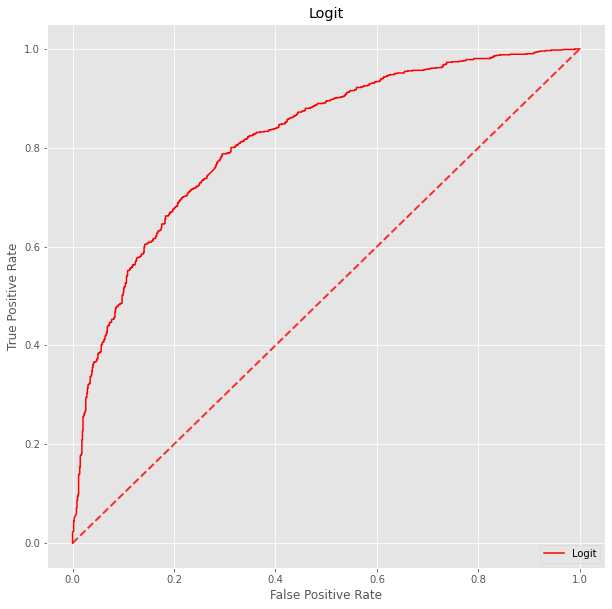

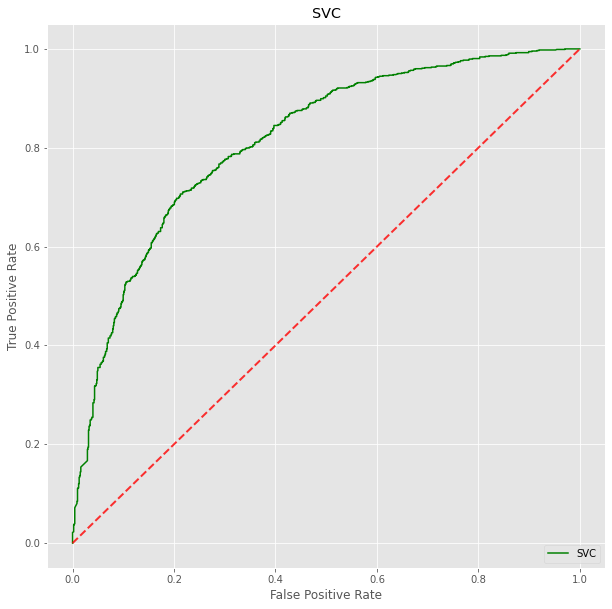

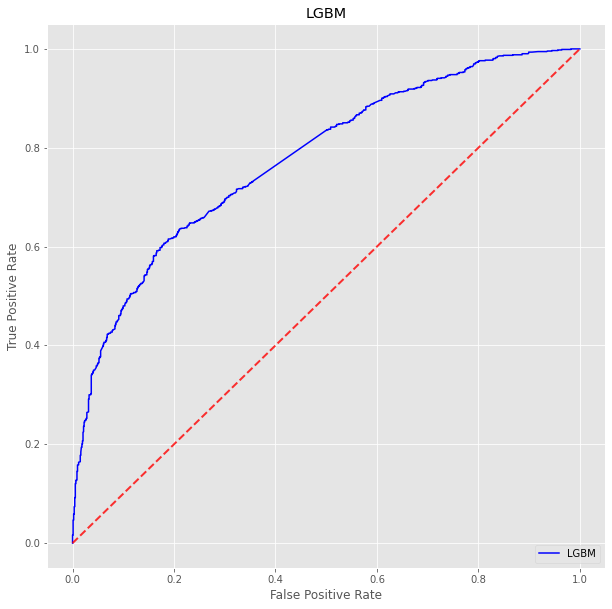

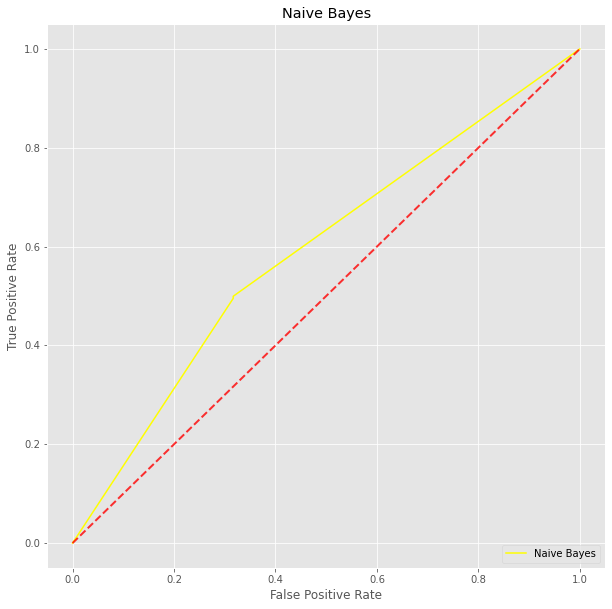

In [19]:
i = 0
colors = ["red", "green", "blue", "yellow"]

for name, clf in zip(names, classifiers):
    print("-" * 50 + "[" + name + "]" + "-" * 50)
    if name == "Naive Bayes":  # Для гаусовского классификатора нужно привести разреженную матрицу к явному виду
        vectorized_train_X = vectorizer.transform(train_X).toarray()
        vectorized_test_X = vectorizer.transform(test_X).toarray() 
    else:
        vectorized_train_X = vectorizer.transform(train_X)
        vectorized_test_X = vectorizer.transform(test_X)

    clf.fit(vectorized_train_X, train_y)

    predictions = clf.predict(vectorized_test_X)
    test_accuracy = metrics.accuracy_score(predictions, test_y)
    
    print(name + " test accuracy: ", test_accuracy)
    
    plot_roc(clf, name, vectorized_test_X, test_y, colors[i])
    i += 1

Как мы видим, наибольшей площадью под кривой обладает SVC (auc_score = 0.74). Попробуем подобрать более точные параметры с помощью **GridSearchCV** из sklearn

In [20]:
# Преобразуем данные
vectorized_train_X = vectorizer.transform(train_X)
vectorized_test_X = vectorizer.transform(test_X)

In [21]:
# Подбираем параметры
params = {"kernel": ["linear", "poly", "rbf"],
          "degree": range(0, 3),
          "C": np.arange(1, 2, 0.5)}

clf = GridSearchCV(SVC(), param_grid = params,
                  cv = 5, scoring = "accuracy")

clf.fit(vectorized_train_X, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1. , 1.5]), 'degree': range(0, 3),
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [22]:
# Лучшие параметры
clf.best_params_

{'C': 1.5, 'degree': 0, 'kernel': 'linear'}

In [23]:
# Лучшая точность
clf.best_score_

0.8504065040650406

In [24]:
model = SVC(C = 1.5, kernel = "linear")
model.fit(vectorized_train_X, train_y)
predictions = model.predict(vectorized_test_X)
metrics.accuracy_score(test_y, predictions)

0.7056910569105691

<AxesSubplot:>

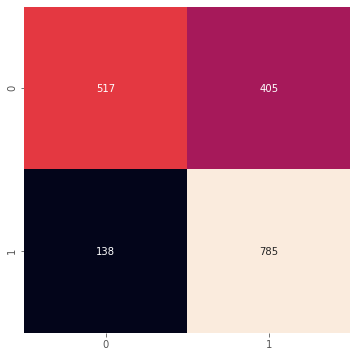

In [25]:
plt.rcParams["figure.figsize"] = (6, 6)
cm = metrics.confusion_matrix(test_y, predictions)
sns.heatmap(cm, square = True, cbar = False, fmt = "d", annot = True, xticklabels=[0, 1], yticklabels=[0, 1])

Как мы видим по матрице путаницы и точности на тестовых данных, стандартные методы машинного обучения по типу SVC - не очень удовлетворяют качеству модели для продакшена.
Посмотрим как справится нейронная сеть на PyTorch

### 5. Модель на PyTorch

In [26]:
# Импортируем необходимые библиотеки
import torch 
import torch.nn as nn

In [27]:
# Приведём разреженные матрицы к формату Torch
torch_X_train = torch.from_numpy(vectorized_train_X.toarray())
torch_X_test = torch.from_numpy(vectorized_test_X.toarray())
train_y = np.array(train_y)
test_y = np.array(test_y)
train_y = torch.from_numpy(train_y).view(train_y.shape[0], 1)
test_y = torch.from_numpy(test_y).view(test_y.shape[0], 1)

In [28]:
torch_X_train.shape, torch_X_test.shape, train_y.shape, test_y.shape

(torch.Size([4305, 4005]),
 torch.Size([1845, 4005]),
 torch.Size([4305, 1]),
 torch.Size([1845, 1]))

In [29]:
n_samples, n_features = torch_X_train.shape

In [43]:
# Построим нашу модель
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        
    def forward(self, x):
        y = torch.sigmoid(self.linear(x))
        return y

In [44]:
model = LogisticRegression(n_features)

In [32]:
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [45]:
num_epochs = 1000
for epoch in range(num_epochs):
    predicted = model(torch_X_train.float())
    loss = criterion(predicted, train_y.float())
    
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    if (epoch + 1) % 200 == 0:
        print(f"epoch: {epoch + 1}, loss = {loss.item()}")

epoch: 200, loss = 0.6971649527549744


KeyboardInterrupt: 

Проверим обученную сеть на тестовом наборе

In [39]:
with torch.no_grad():
    predicted = model(torch_X_test.float())
    y_predicted_cls = predicted.round()
    
metrics.accuracy_score(y_predicted_cls, test_y)

0.5002710027100271

Что ж, нейронная сеть тоже справилась не так уж и хорошо. Скорее всего, виной тому неправильная предобработка входных данных

### 6. Пытаемся улучшить качество моделей

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve, learning_curve

In [74]:
# Рисуем графики кросс-валидации
def plot_validation(param, score, **kwargs):
    mu, std = score.mean(1), score.std(1)
    lines = plt.plot(param, mu, '-', **kwargs)
    plt.fill_between(param, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

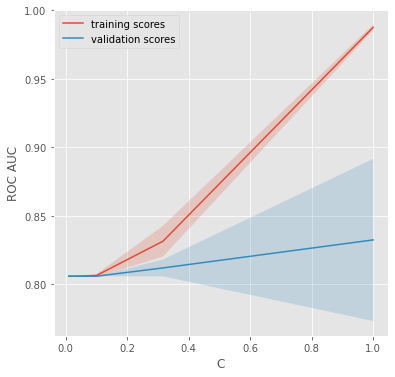

In [76]:
# Попытаемся подобрать параметр C для метода опорных векторов
C = np.logspace(-2, 0, 5)
clf = SVC(kernel = "rbf")
svc_pipeline = Pipeline([("svc", clf)])

val_train, val_test = validation_curve(svc_pipeline, vectorized_train_X, train_y, param_name = 'svc__C',
                                      param_range = C, cv = 5, scoring = "accuracy")

plot_validation(C, val_train, label='training scores')
plot_validation(C, val_test, label='validation scores')
plt.xlabel('C'); 
plt.ylabel('ROC AUC')
plt.legend();

Наши валидационные кривые слишком сильно отличаются, что говорит нам о том, что наша модель **переобучилась**, таким образом, наша модель отвлекается на шум и упускает основной тренд.
Построим теперь кривые обучения и посмотрим

In [82]:
def plot_learning_curve(param, X, y):
    train_sizes = np.linspace(0.05, 1, 20)
    clf = SVC(C = param, kernel = "rbf")
    svc_pipeline = Pipeline([("svc", clf)])
    
    N_train, val_train, val_test = learning_curve(svc_pipeline, X, y,
                                                 train_sizes = train_sizes, cv = 5, scoring = "roc_auc")
    plot_validation(N_train, val_train, label = "training_scores")
    plot_validation(N_train, val_test, label = "validation scores")
    plt.xlabel("Training set Size")
    plt.ylabel("ROC AUC")
    plt.legend()

In [79]:
all_data_vectorized = TfidfVectorizer().fit_transform(clear_dict["data"])
all_data_vectorized

<6150x5861 sparse matrix of type '<class 'numpy.float64'>'
	with 54466 stored elements in Compressed Sparse Row format>

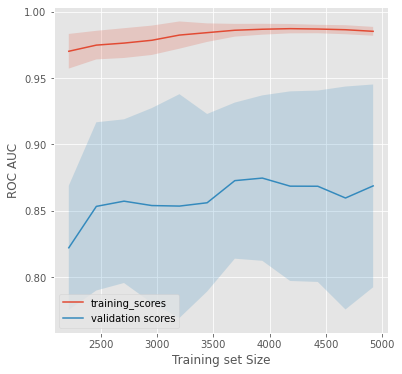

In [84]:
plot_learning_curve(0.2, all_data_vectorized, clear_dict["target"])

Как мы видим, при увеличении объёма данных, валидационная кривая подходит к тренировочной. Это говорит о том, что мы можем улучшить результат, если соберём ещё больше данных